In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib

In [2]:
# Install kagglehub if not already installed
%pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("kartik2112/fraud-detection")

print("Path to dataset files:", path)

  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl (156 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
d:\Project\Credit-Card-Fraud-Detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 202M/202M [00:47<00:00, 4.44MB/s] 

Extracting files...


Path to dataset files: C:\Users\Ninaad Saxena\.cache\kagglehub\datasets\kartik2112\fraud-detection\versions\1


In [3]:
train_df = pd.read_csv(f"{path}/fraudTrain.csv")
train_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
test_df = pd.read_csv(f"{path}/fraudTest.csv")
test_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [5]:
df = pd.concat([train_df, test_df], ignore_index=True)

In [7]:
# Ensure 'trans_date_trans_time' is in datetime format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df['trans_date'] = df['trans_date_trans_time']
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

In [8]:
drop_columns = ['Unnamed: 0', 'trans_date_trans_time','first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'job', 'trans_num']
df = df.drop(columns=drop_columns)

In [9]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,trans_date,hour,day,month
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,2019-01-01 00:00:18,0,1,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,2019-01-01 00:00:44,0,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,2019-01-01 00:00:51,0,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,2019-01-01 00:01:16,0,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,2019-01-01 00:03:06,0,1,1


In [10]:
cat_col = ['merchant', 'category','gender']
encoders = {}
for col in cat_col:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

In [12]:
def haversine(lat1, lon1, lat2, lon2):
    return np.array([geodesic((a, b), (c, d)).km for a,b,c,d in zip(lat1, lon1, lat2, lon2)])

df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

In [13]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,trans_date,hour,day,month,distance
0,2703186189652095,514,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,2019-01-01 00:00:18,0,1,1,78.773821
1,630423337322,241,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,2019-01-01 00:00:44,0,1,1,30.216618
2,38859492057661,390,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,2019-01-01 00:00:51,0,1,1,108.102912
3,3534093764340240,360,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,2019-01-01 00:01:16,0,1,1,95.685115
4,375534208663984,297,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,2019-01-01 00:03:06,0,1,1,77.702395


In [14]:
features = ['merchant', 'category', 'amt', 'cc_num', 'hour', 'day', 'month', 'gender', 'distance']
x = df[features]
y = df['is_fraud']

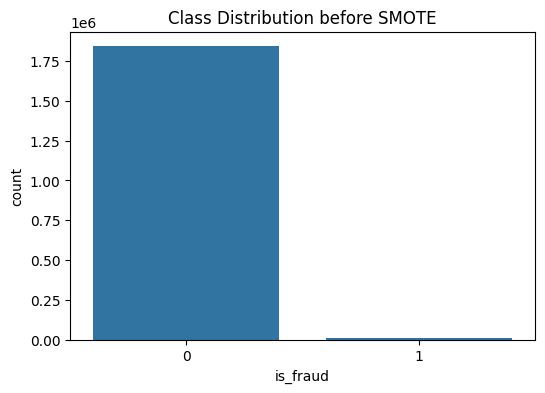

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df)
plt.title('Class Distribution before SMOTE')
plt.show()

In [16]:
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

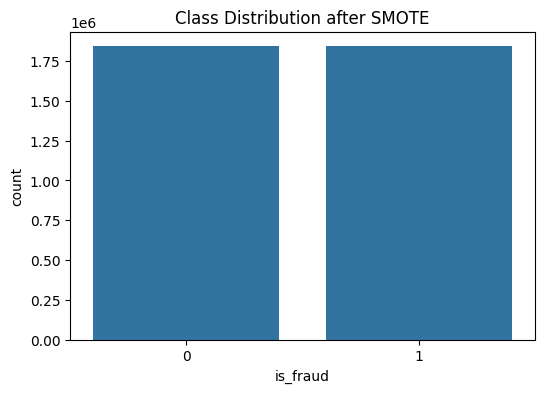

In [18]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title('Class Distribution after SMOTE')
plt.show()

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

In [21]:
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metrics='auc',
    is_unbalance=True,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=1,
    n_estimators=200
)

lgb_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 1473811, number of negative: 1474577
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2948388, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499870 -> initscore=-0.000520
[LightGBM] [Info] Start training from score -0.000520
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(is_unbalance=True, learning_rate=0.05, max_depth=1,
               metrics='auc', n_estimators=200, objective='binary')

In [22]:
y_pred = lgb_model.predict(x_test)

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.96      0.88    368166
           1       0.95      0.78      0.86    368932

    accuracy                           0.87    737098
   macro avg       0.88      0.87      0.87    737098
weighted avg       0.88      0.87      0.87    737098

ROC AUC Score: 0.8696438685208517


In [ ]:
# Get feature importance values
feature_importance = lgb_model.feature_importances_

# Map feature importance to feature names
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

    Feature  Importance
2       amt         117
1  category          50
4      hour          26
0  merchant           4
6     month           3
3    cc_num           0
5       day           0
7    gender           0
8  distance           0


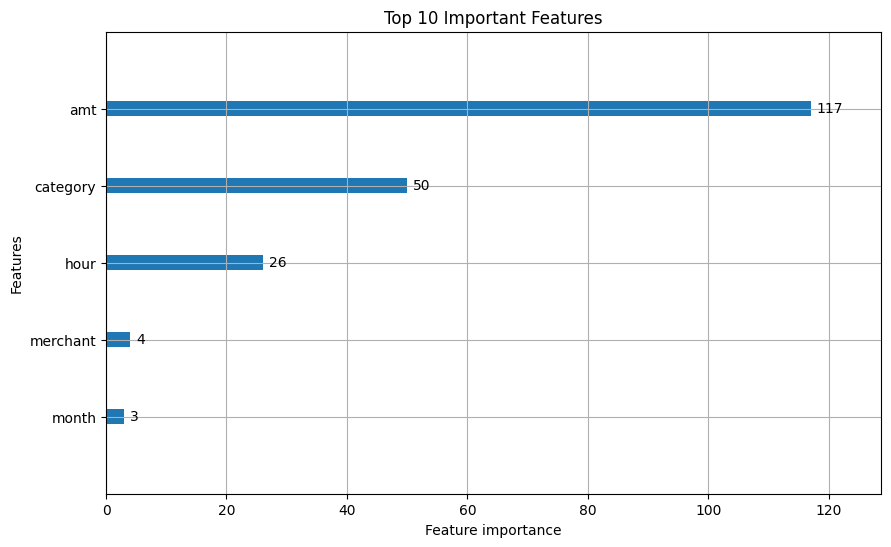

In [29]:
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='split', figsize=(10, 6))
plt.title('Top 10 Important Features')
plt.show()

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, lgb_model.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)

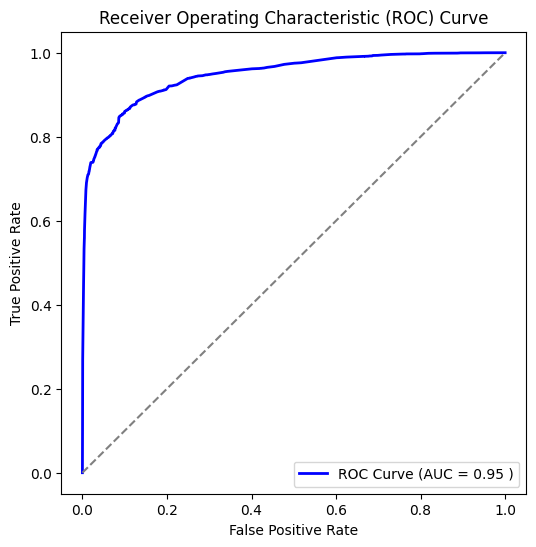

In [31]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label = f'ROC Curve (AUC = {roc_auc:.2f} )')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [33]:
joblib.dump(lgb_model, 'fraud_detection_model.jb')
joblib.dump(encoders, 'label_encoder.jb')

['label_encoder.jb']